<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/main/model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - CV
    - best_params_
    - Short list of models
    - sklearn.metrics module

# Imports

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
# PEP 8
%%capture
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

# Setup paths

In [4]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/5.RestaurantRevenue/'

train_path = gdrive_path + df_path + "train.csv"
train_processed_path = gdrive_path + df_path + "trainval_processed.csv"
test_processed_path = gdrive_path + df_path + "test_processed.csv"
test_path =  gdrive_path + df_path + "test.csv"
submission_path = gdrive_path + df_path + "submission.csv"
sample_submission_path = gdrive_path + df_path + "sampleSubmission.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Download the data

In [5]:
df_test = pd.read_csv(test_processed_path, index_col=[0])
df_test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-1.032819,-1.653875,0.688913,-1.382555,-0.807152,-0.633614,-2.019553,-0.062452,-0.217343,-0.244523,...,-0.606797,-0.556056,-0.652386,2008.0,0.0,0.0,1.0,0.0,1.134031,14.842280
1,0.015056,0.397991,-0.268140,-1.382555,-0.807152,-0.159426,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,0.511872,2007.0,0.0,0.0,0.0,1.0,1.769000,15.312391


In [6]:
df_trainval = pd.read_csv(train_processed_path, index_col=[0])
df_trainval.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-0.334236,-0.285964,-1.225193,-0.383325,0.014161,-0.633614,-0.182156,-0.062452,-0.217343,-0.244523,...,0.655776,0.253599,1.094000,2009.0,0.0,0.0,0.0,1.0,2.069,15.278005
1,-0.683527,-0.285964,-1.225193,0.615905,1.656785,0.788952,-0.182156,-0.619713,-0.790338,-0.811816,...,-0.606797,-0.556056,-0.652386,2007.0,1.0,0.0,1.0,0.0,5.663,15.255171


In [7]:
X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

In [8]:
X_test = df_test.values[:, :-1]
Y_test = df_test.values[:, -1]

# Select and train models (+ ensemble methods)

## Define models

In [9]:
from dataclasses import dataclass, field

@dataclass
class Model:
    model: None
    name: str
    grid_search_param_grid: list 
    random_search_param_grid: list

In [10]:
RFModel = Model(
    RandomForestRegressor(),
    'RF',
    [
        {'n_estimators': [100, 200, 500]}
    ],

    [
        {
            'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
            'max_depth': [i for i in range(1, 20)]
        }
    ]
)

ElasticNetModel = Model(
    ElasticNet(),
    'Elastic',
    [
        {
            'alpha': [0.1, 0.3, 0.5],
            'l1_ratio': [0.2, 0.4]
        }, 
    ],
    [
        {}
    ]
)

SVRModel = Model(
    SVR(),
    'SVM reg',
    [
        {}
    ],
    [
        {}
    ]
)

In [11]:
all_models = {
    model.name: model for model in [RFModel, SVRModel, ElasticNetModel]
}

## Preliminary look (shortlisting 2-5 models)

## Cross validation result

In [12]:
def plot_model_scores(models_dict_, X_, Y_, cv_, scoring_):
    res = {}
    for name, model in models_dict_.items():
        scores = cross_val_score(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_
        )
        res[name] = scores
    
    # Sort the dict
    sorted_res = {
        k:v for \
        k, v in sorted(res.items(), key = lambda item: np.mean(item[1]))
    }
    for model_name, scores in sorted_res.items():
        print(f'Model: {model_name}, mean: {np.mean(scores)}, std: {np.std(scores)}')

    return sorted_res

In [13]:
_ = plot_model_scores(
    {
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=7,
    scoring_='neg_mean_squared_error'
)

Model: SVM reg, mean: -0.23975755066794463, std: 0.10254520924351965
Model: Elastic, mean: -0.21569093211351922, std: 0.10074172443016455
Model: RF, mean: -0.18960803816359784, std: 0.060165399563163684


## Overfitting behavior

In [37]:
pycodestyle
from sklearn.model_selection import cross_validate


def plot_cv_results(models_dict_, X_, Y_, cv_, scoring_):

    for model_name, model in models_dict_.items():
        cv_res = cross_validate(
            model,
            X_,
            Y_,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True
        )

        _, ax = plt.subplots()
        x = np.arange(len(cv_res['test_score']))
        width = 0.5
        ax.bar(x - width / 2, cv_res['test_score'], width, label='validation')
        ax.bar(x + width / 2, cv_res['train_score'], width, label='train')
        
        ax.set_title(f'Results for {model_name}')
        ax.set_xlabel(f'CV fold number')
        ax.set_ylabel(f'Metrics: {scoring_}')
        
        ax.legend()
        ax.grid()

NameError: ignored

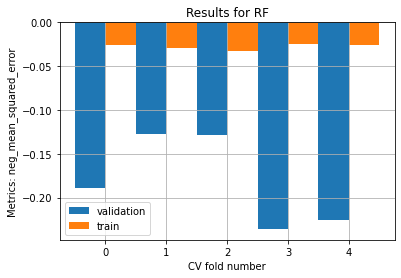

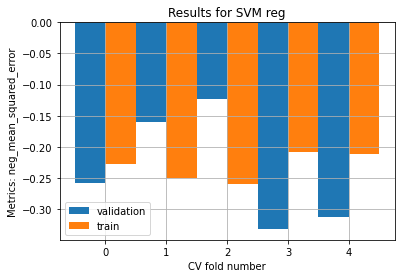

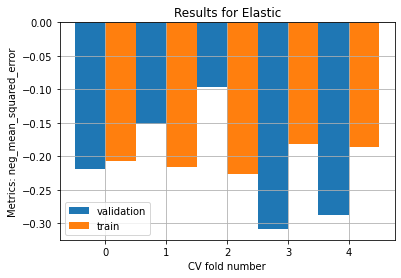

In [38]:
# %%pycodestyle
plot_cv_results(
    models_dict_={
        model_name: model.model for model_name, model in all_models.items()
    },
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    scoring_='neg_mean_squared_error'
)

In [16]:
shortlisted_models = {
    model.name: model for model in [RFModel, ElasticNetModel, SVRModel]
}

# Fine tuning

## Grid search

In [17]:
def fit_grid_search(models_dict_, X_, Y_, cv_, scoring_):
    res = {
        name: None for name in list(models_dict_.keys())
    }
    print(models_dict_.items())
    for name, model in models_dict_.items():
        print(f'Fitting {name}')
        
        grid_search_estimator = GridSearchCV(
            model.model,
            param_grid=model.grid_search_param_grid,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True,
            refit=True
        )

        grid_search_result = grid_search_estimator.fit(X_, Y_)
        res[name] = grid_search_result
    return res

In [18]:
shortlisted_models

{'RF': Model(model=RandomForestRegressor(), name='RF', grid_search_param_grid=[{'n_estimators': [100, 200, 500]}], random_search_param_grid=[{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}]),
 'Elastic': Model(model=ElasticNet(), name='Elastic', grid_search_param_grid=[{'alpha': [0.1, 0.3, 0.5], 'l1_ratio': [0.2, 0.4]}], random_search_param_grid=[{}]),
 'SVM reg': Model(model=SVR(), name='SVM reg', grid_search_param_grid=[{}], random_search_param_grid=[{}])}

In [19]:
grid_search_results = fit_grid_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_ = 5,
    scoring_ = 'neg_mean_squared_error'
)

AAA
{'RF': Model(model=RandomForestRegressor(), name='RF', grid_search_param_grid=[{'n_estimators': [100, 200, 500]}], random_search_param_grid=[{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}]), 'Elastic': Model(model=ElasticNet(), name='Elastic', grid_search_param_grid=[{'alpha': [0.1, 0.3, 0.5], 'l1_ratio': [0.2, 0.4]}], random_search_param_grid=[{}]), 'SVM reg': Model(model=SVR(), name='SVM reg', grid_search_param_grid=[{}], random_search_param_grid=[{}])}
dict_items([('RF', Model(model=RandomForestRegressor(), name='RF', grid_search_param_grid=[{'n_estimators': [100, 200, 500]}], random_search_param_grid=[{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}])), ('Elastic', Model(model=ElasticNet(), name='Elastic', grid_search_param_grid=[{'alpha': [0.1, 0.3, 0.5], 'l1_ratio': [0.2, 0.4]}], random_search

In [20]:
print(grid_search_results['RF'].best_params_)
print(grid_search_results['Elastic'].best_estimator_)

{'n_estimators': 500}
ElasticNet(alpha=0.5, l1_ratio=0.2)


## Randomized search

In [40]:
%%pycodestyle
from sklearn.model_selection import RandomizedSearchCV


def fit_randomized_search(models_dict_, X_, Y_, cv_, n_iter_, scoring_):
    RANDOM_STATE = 42
    res = {}
    for name, model in models_dict_.items():
        print(f'Fitting {name}')

        estimator = RandomizedSearchCV(
            model.model,
            param_distributions=model.random_search_param_grid,
            cv=cv_,
            n_iter=n_iter_,
            scoring=scoring_,
            return_train_score=True,
            refit=True,
            random_state=RANDOM_STATE
        )

        rand_search_res = estimator.fit(X_, Y_)
        res[name] = rand_search_res
    return res

INFO:pycodestyle:25:1: W391 blank line at end of file


In [41]:
rand_search_results = fit_randomized_search(
    shortlisted_models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=5,
    n_iter_=10,
    scoring_='neg_mean_squared_error'
)

Fitting RF
Fitting Elastic
Fitting SVM reg


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [27]:
print(rand_search_results['RF'].best_estimator_)
print(rand_search_results['SVM reg'].best_estimator_)

RandomForestRegressor(max_depth=9, n_estimators=500)
SVR()


# Model mistake analysis

- From feature importance analysis, we see that the most important features are **opening year** and **city population**

## Feature importances

- Here, we definitely see how engineered features (**population** and **year of opening**) are more important to the decision tree algorithm

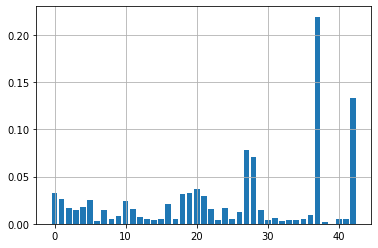

In [29]:
plt.bar(
    np.arange(len(grid_search_results['RF'].best_estimator_.feature_importances_)),
    grid_search_results['RF'].best_estimator_.feature_importances_
)
plt.grid()

## Visualize predictions

In [65]:
# %%pycodestyle
def visualize_regression_predictions(sklearn_models_, X_, Y_, dataset_type_):
    _, ax = plt.subplots()
    ax.plot(
            Y_,
            label=f'{dataset_type_} target'
    )

    for model in sklearn_models_:
        predictions = model.predict(X_)
        model_name = model.__class__.__name__
        ax.scatter(
            x=np.arange(len(predictions)),
            y=predictions,
            label=f'{model_name} predictions'
        )
        
    ax.set_xlabel('Dataset instance')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Visualized predictons on {dataset_type_}')

    ax.legend()
    ax.grid()

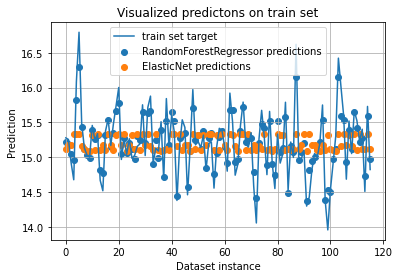

In [67]:
visualize_regression_predictions(
    sklearn_models_=[
        rand_search_results['RF'].best_estimator_,
        rand_search_results['Elastic'].best_estimator_
    ],
    X_=X_train_val,
    Y_=Y_train_val,
    dataset_type_='train set'
)

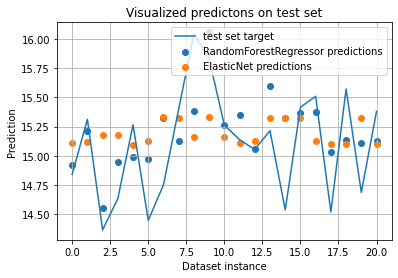

In [71]:
# %%pycodestyle
visualize_regression_predictions(
    sklearn_models_=[
        rand_search_results['RF'].best_estimator_,
        rand_search_results['Elastic'].best_estimator_
    ],
    X_=X_test,
    Y_=Y_test,
    dataset_type_='test set'
)

# Saving best models (pickle)